In [1]:
import os
os.chdir(os.path.expanduser("~/Projects/zimmer"))
import copy
import pickle

import numpy as np
np.random.seed(1234)

import matplotlib.pyplot as plt
plt.ion()

from tqdm import tqdm
from functools import partial

from zimmer.io import load_kato_data
import zimmer.plotting as zplt
from zimmer.observations import HierarchicalIndependentAutoRegressiveObservations, HierarchicalAutoRegressiveObservations,  HierarchicalRobustAutoRegressiveObservations
from zimmer.transitions import HierarchicalStationaryTransitions, HierarchicalRecurrentTransitions, HierarchicalRecurrentOnlyTransitions, HierarchicalNeuralNetworkRecurrentTransitions
from zimmer.util import cached

from ssm.models import HMM
from ssm.core import _HMM
from ssm.init_state_distns import InitialStateDistribution
from ssm.transitions import RecurrentTransitions, InputDrivenTransitions, StationaryTransitions, \
    NeuralNetworkRecurrentTransitions, RecurrentOnlyTransitions
from ssm.observations import IndependentAutoRegressiveObservations

from ssm.util import find_permutation, compute_state_overlap
from ssm.preprocessing import pca_with_imputation, trend_filter, standardize

In [15]:
# Specify hyperparameters
D = 10   # dimensionality of continuous latent states
M = 0   # dimensionality of input
results_dir = "results/kato/2018-10-09/D{}".format(D)

In [16]:
# Load the data
ys, ms, z_trues, z_true_key, neuron_names = load_kato_data(include_unnamed=False, signal="dff")
ys = [trend_filter(y) for y in ys]


K_true = len(z_true_key)
N = ys[0].shape[1]
W = len(ys)
Ts = [y.shape[0] for y in ys]

Only including named neurons.
59 neurons across all 5 worms


# Dimensionality reduction on $\Delta$F/F 

In [17]:
# Run PCA to get a 3d projection of the data
from ssm.preprocessing import pca_with_imputation
_pca = cached(results_dir, "pca")(pca_with_imputation)
pca, xs = pca_with_imputation(D, ys, ms)

lim = 1.1 * abs(np.vstack(xs)).max()

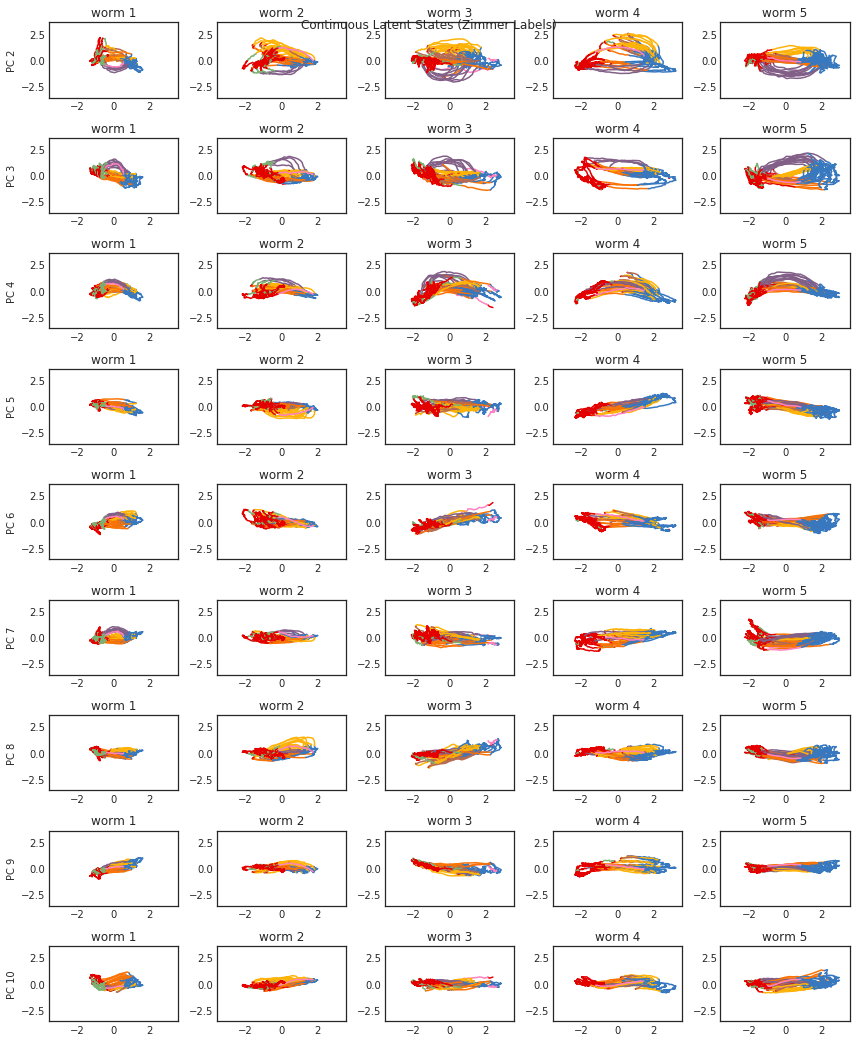

In [18]:
plt.figure(figsize=(12, 16))
for w, (x, z) in enumerate(zip(xs, z_trues)):
    for d in range(1, D):
        ax = plt.subplot(D, W, (d-1) * W + w+1)
        zplt.plot_2d_continuous_states(x, z, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, d), ax=ax)
        plt.ylabel("PC {}".format(d+1) if w == 0 else "")
        plt.title("worm {}".format(w+1))

plt.suptitle("Continuous Latent States (Zimmer Labels)")
plt.tight_layout()

In [28]:
xs = [x.copy('C') for x in xs]

# Reconstruct from PCA

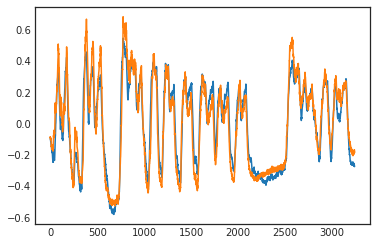

In [19]:
C = pca.components_.T
d = pca.mean_
y_hats = [x.dot(C.T) + d for x in xs]

plt.plot(y_hats[0][:,0])
plt.plot(ys[0][:,0])

In [20]:
np.sqrt(pca.noise_variance_)

0.07786192614053207

# Evaluate PCA component loadings

Cluster  0
RIVL

Cluster  1
AIBL
AIBR
ASKL
AVER
OLQDL
OLQDR
SAAVL
SIBDR
SMDVR

Cluster  2
AVBL
AVBR
RIBL
RIBR
RIFR

Cluster  3
SABD
URADL
URADR
URYDR
URYVL
URYVR
VA01

Cluster  4
DB01
DB02
VB01
VB02

Cluster  5
RMEV

Cluster  6
RIVR
SMDVL

Cluster  7
AVAL
AVAR
RIML
RIMR

Cluster  8
AVEL
RIS
RMED

Cluster  9
SMDDL

Cluster  10
ALA
ASKR
AVFL
AVFR
BAGL
OLQVL
OLQVR
RID
RIGL
RIGR
RMEL
RMER
SAAVR
SABVL
SABVR
SIADL
SIBVL
SIBVR
SMDDR
URYDL

Cluster  11
AS01
DA01



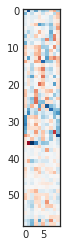

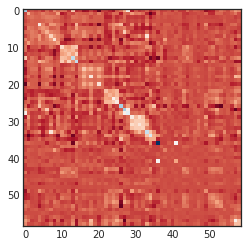

In [21]:
from sklearn.cluster import KMeans
C = pca.components_.T
km = KMeans(12)
km.fit(C)
Cp = C[np.argsort(km.labels_)]
plt.imshow(Cp, vmin=-abs(C).max(), vmax=abs(C).max(), cmap="RdBu")

plt.figure()
plt.imshow(Cp.dot(Cp.T), cmap="RdBu")

for k in range(km.n_clusters):
    print("Cluster ", k)
    for name in [name for kn, name in zip(km.labels_, neuron_names) if kn == k]:
        print(name)
        
    print("")

# Split into train/test/validation

In [30]:
np.random.seed(0)

chunk = 250
train_frac = 0.7
val_frac = 0.15
all_ys = []
all_xs = []
all_ms = []
all_tags = []
all_z_trues = []
all_choices = []
for tag, (y, x, m, ztr) in enumerate(zip(ys, xs, ms, z_trues)):
    T = y.shape[0]
    C = 0
    for start in range(0, T, chunk):
        stop = min(start+chunk, T)
        all_ys.append(y[start:stop])
        all_xs.append(x[start:stop].copy('C'))
        all_ms.append(m[start:stop])
        all_z_trues.append(ztr[start:stop])
        all_tags.append(tag)
        C += 1
        
    # assign some of the data to train, val, and test
    choices = -1 * np.ones(C)
    choices[:int(train_frac * C)] = 0
    choices[int(train_frac * C):int((train_frac + val_frac) * C)] = 1
    choices[int((train_frac + val_frac) * C):] = 2
    choices = choices[np.random.permutation(C)]
    all_choices.append(choices)

all_choices = np.concatenate(all_choices)
get = lambda arr, chc: [x for x, c in zip(arr, all_choices) if c == chc]

train_ys = get(all_ys, 0)
train_xs = get(all_xs, 0)
train_ms = get(all_ms, 0)
train_zs = get(all_z_trues, 0)
train_tags = get(all_tags, 0)

val_ys = get(all_ys, 1)
val_xs = get(all_xs, 1)
val_ms = get(all_ms, 1)
val_zs = get(all_z_trues, 1)
val_tags = get(all_tags, 1)

test_ys = get(all_ys, 2)
test_xs = get(all_xs, 2)
test_ms = get(all_ms, 2)
test_zs = get(all_z_trues, 2)
test_tags = get(all_tags, 2)

In [31]:
print("Training chunks per worm:   ", np.bincount(train_tags))
print("Validation chunks per worm: ", np.bincount(val_tags))
print("Testing chunks per worm:    ", np.bincount(test_tags))

Training chunks per worm:    [9 9 9 9 9]
Validation chunks per worm:  [2 2 2 2 2]
Testing chunks per worm:     [2 2 2 2 2]


In [32]:
# Compute number of training, validation, and test entries
D_train = sum([x.size for x in train_xs])
D_val = sum([x.size for x in val_xs])
D_test = sum([x.size for x in test_xs])

print("D_train: ", D_train)
print("D_val:   ", D_val)
print("D_test:  ", D_test)

D_train:  112070
D_val:    25000
D_test:   24890


# Fit an ARHMM to the continuous latent states, sweeping over number of discrete latent states

In [33]:
Ks = np.arange(2, 21, step=2)
transitionss = ["standard", "recurrent"]
observationss = ["ar", "robust_ar"]
etas = [1e-1, 1e-2, 1e-3, 1e-4]

In [34]:
def _fit_hmm(K, transitions, observations):
    hmm = HMM(K, D, M, transitions=transitions, observations=observations)
    lps = hmm.fit(train_xs, method="em", num_em_iters=250)
    val_ll = hmm.log_likelihood(val_xs)
    return hmm, lps, val_ll

In [ ]:
hmm_results = {}
for K in Ks:
    for transitions in transitionss:
        for observations in observationss:
            hmm_results_name = "hmm_{}_{}_K{}".format(transitions, observations, K)
            fit = cached(results_dir, hmm_results_name)(_fit_hmm)
            
            print("Fitting ", hmm_results_name)
            hmm_results[hmm_results_name] = fit(K, transitions, observations)
            
with open(os.path.join(results_dir, "hmm_results.pkl"), "wb") as f:
    pickle.dump(hmm_results, f)




  0%|          | 0/250 [00:00<?, ?it/s]


LP: 184941.7:   0%|          | 0/250 [00:00<?, ?it/s]

Fitting  hmm_standard_ar_K2
Fitting  hmm_standard_robust_ar_K2





LP: 184941.7:   0%|          | 0/250 [00:00<?, ?it/s]


LP: 184941.7:   0%|          | 1/250 [00:00<00:53,  4.68it/s]


LP: 193056.3:   0%|          | 1/250 [00:00<01:20,  3.10it/s]


LP: 193056.3:   1%|          | 2/250 [00:00<00:40,  6.17it/s]


LP: 196068.6:   1%|          | 2/250 [00:00<00:54,  4.55it/s]


LP: 196068.6:   1%|          | 3/250 [00:00<00:36,  6.79it/s]


LP: 197363.8:   1%|          | 3/250 [00:00<00:45,  5.48it/s]


LP: 197363.8:   2%|▏         | 4/250 [00:00<00:33,  7.29it/s]


LP: 197775.5:   2%|▏         | 4/250 [00:00<00:40,  6.09it/s]


LP: 197775.5:   2%|▏         | 5/250 [00:00<00:32,  7.59it/s]


LP: 197909.5:   2%|▏         | 5/250 [00:00<00:37,  6.52it/s]


LP: 197909.5:   2%|▏         | 6/250 [00:00<00:31,  7.81it/s]


LP: 197973.9:   2%|▏         | 6/250 [00:00<00:35,  6.85it/s]


LP: 197973.9:   3%|▎         | 7/250 [00:00<00:30,  7.98it/s]


LP: 198022.7:   3%|▎         | 7/250 [00:00<00:34,  7.11it/s]


LP: 198022.7:   3%|▎         | 8/250 [00:00<0

LP: 198206.4:  22%|██▏       | 56/250 [00:06<00:23,  8.32it/s]


LP: 198205.4:  22%|██▏       | 56/250 [00:06<00:23,  8.10it/s]


LP: 198205.4:  23%|██▎       | 57/250 [00:06<00:23,  8.25it/s]


LP: 198204.6:  23%|██▎       | 57/250 [00:07<00:23,  8.10it/s]


LP: 198204.6:  23%|██▎       | 58/250 [00:07<00:23,  8.24it/s]


LP: 198204.4:  23%|██▎       | 58/250 [00:07<00:23,  8.07it/s]


LP: 198204.4:  24%|██▎       | 59/250 [00:07<00:23,  8.21it/s]


LP: 198204.8:  24%|██▎       | 59/250 [00:07<00:23,  8.04it/s]


LP: 198204.8:  24%|██▍       | 60/250 [00:07<00:23,  8.18it/s]


LP: 198205.1:  24%|██▍       | 60/250 [00:07<00:24,  7.89it/s]


LP: 198205.1:  24%|██▍       | 61/250 [00:07<00:23,  8.02it/s]


LP: 198204.3:  24%|██▍       | 61/250 [00:07<00:23,  7.89it/s]


LP: 198204.3:  25%|██▍       | 62/250 [00:07<00:23,  8.01it/s]


LP: 198203.1:  25%|██▍       | 62/250 [00:07<00:23,  7.87it/s]


LP: 198203.1:  25%|██▌       | 63/250 [00:07<00:23,  7.99it/s]


LP: 198203.8:  25%|██▌   

LP: 198298.1:  44%|████▍     | 111/250 [00:14<00:18,  7.45it/s]


LP: 198298.2:  44%|████▍     | 111/250 [00:15<00:18,  7.40it/s]


LP: 198298.2:  45%|████▍     | 112/250 [00:15<00:18,  7.46it/s]


LP: 198298.2:  45%|████▍     | 112/250 [00:15<00:18,  7.39it/s]


LP: 198298.2:  45%|████▌     | 113/250 [00:15<00:18,  7.45it/s]


LP: 198298.2:  45%|████▌     | 113/250 [00:15<00:18,  7.32it/s]


LP: 198298.2:  46%|████▌     | 114/250 [00:15<00:18,  7.38it/s]


LP: 198298.2:  46%|████▌     | 114/250 [00:15<00:18,  7.26it/s]


LP: 198298.2:  46%|████▌     | 115/250 [00:15<00:18,  7.32it/s]


LP: 198298.2:  46%|████▌     | 115/250 [00:15<00:18,  7.28it/s]


LP: 198298.2:  46%|████▋     | 116/250 [00:15<00:18,  7.34it/s]


LP: 198298.2:  46%|████▋     | 116/250 [00:15<00:18,  7.29it/s]


LP: 198298.2:  47%|████▋     | 117/250 [00:15<00:18,  7.35it/s]


LP: 198298.3:  47%|████▋     | 117/250 [00:16<00:18,  7.30it/s]


LP: 198298.3:  47%|████▋     | 118/250 [00:16<00:17,  7.36it/s]


LP: 198298

LP: 198298.5:  66%|██████▌   | 165/250 [00:22<00:11,  7.20it/s]


LP: 198298.5:  66%|██████▋   | 166/250 [00:22<00:11,  7.24it/s]


LP: 198298.5:  66%|██████▋   | 166/250 [00:23<00:11,  7.17it/s]


LP: 198298.5:  67%|██████▋   | 167/250 [00:23<00:11,  7.21it/s]


LP: 198298.5:  67%|██████▋   | 167/250 [00:23<00:11,  7.17it/s]


LP: 198298.5:  67%|██████▋   | 168/250 [00:23<00:11,  7.21it/s]


LP: 198298.5:  67%|██████▋   | 168/250 [00:23<00:11,  7.17it/s]


LP: 198298.5:  68%|██████▊   | 169/250 [00:23<00:11,  7.21it/s]


LP: 198298.5:  68%|██████▊   | 169/250 [00:23<00:11,  7.17it/s]


LP: 198298.5:  68%|██████▊   | 170/250 [00:23<00:11,  7.21it/s]


LP: 198298.5:  68%|██████▊   | 170/250 [00:23<00:11,  7.16it/s]


LP: 198298.5:  68%|██████▊   | 171/250 [00:23<00:10,  7.20it/s]


LP: 198298.5:  68%|██████▊   | 171/250 [00:23<00:11,  7.13it/s]


LP: 198298.5:  69%|██████▉   | 172/250 [00:23<00:10,  7.18it/s]


LP: 198298.5:  69%|██████▉   | 172/250 [00:24<00:10,  7.15it/s]


LP: 198298

LP: 198298.6:  88%|████████▊ | 220/250 [00:31<00:04,  7.04it/s]


LP: 198298.6:  88%|████████▊ | 220/250 [00:31<00:04,  7.02it/s]


LP: 198298.6:  88%|████████▊ | 221/250 [00:31<00:04,  7.05it/s]


LP: 198298.6:  88%|████████▊ | 221/250 [00:31<00:04,  7.03it/s]


LP: 198298.6:  89%|████████▉ | 222/250 [00:31<00:03,  7.06it/s]


LP: 198298.6:  89%|████████▉ | 222/250 [00:31<00:03,  7.04it/s]


LP: 198298.6:  89%|████████▉ | 223/250 [00:31<00:03,  7.07it/s]


LP: 198298.6:  89%|████████▉ | 223/250 [00:31<00:03,  7.04it/s]


LP: 198298.6:  90%|████████▉ | 224/250 [00:31<00:03,  7.08it/s]


LP: 198298.6:  90%|████████▉ | 224/250 [00:31<00:03,  7.05it/s]


LP: 198298.6:  90%|█████████ | 225/250 [00:31<00:03,  7.08it/s]


LP: 198298.6:  90%|█████████ | 225/250 [00:31<00:03,  7.06it/s]


LP: 198298.6:  90%|█████████ | 226/250 [00:31<00:03,  7.09it/s]


LP: 198298.6:  90%|█████████ | 226/250 [00:31<00:03,  7.07it/s]


LP: 198298.6:  91%|█████████ | 227/250 [00:31<00:03,  7.10it/s]


LP: 198298

Fitting  hmm_recurrent_ar_K2






LP: 182189.5:   0%|          | 0/250 [00:00<?, ?it/s]


LP: 182189.5:   0%|          | 1/250 [00:00<02:32,  1.64it/s]


LP: 190157.3:   0%|          | 1/250 [00:01<04:46,  1.15s/it]


LP: 190157.3:   1%|          | 2/250 [00:01<02:22,  1.74it/s]


LP: 192753.9:   1%|          | 2/250 [00:01<03:30,  1.18it/s]


LP: 192753.9:   1%|          | 3/250 [00:01<02:19,  1.77it/s]


LP: 193713.7:   1%|          | 3/250 [00:02<03:02,  1.35it/s]


LP: 193713.7:   2%|▏         | 4/250 [00:02<02:16,  1.80it/s]


LP: 194061.9:   2%|▏         | 4/250 [00:02<02:49,  1.45it/s]


LP: 194061.9:   2%|▏         | 5/250 [00:02<02:15,  1.81it/s]


LP: 194250.0:   2%|▏         | 5/250 [00:03<02:40,  1.53it/s]


LP: 194250.0:   2%|▏         | 6/250 [00:03<02:13,  1.83it/s]

# Fit hierarchical HMMs

In [14]:
def _fit_hierarchical_hmm(K, transitions, observations, hmm, eta):
    # Construct the HMM components
    init_state_distn = InitialStateDistribution(K, D, M)

    transition_classes = dict(standard=HierarchicalStationaryTransitions,
                              recurrent=HierarchicalRecurrentTransitions)
    transition_distn = transition_classes[transitions](K, D, W, M, eta=eta)
    
    observation_classes = dict(ar=HierarchicalAutoRegressiveObservations, 
                               independent_ar=HierarchicalIndependentAutoRegressiveObservations,
                               robust_ar=HierarchicalRobustAutoRegressiveObservations)
    observation_distn = observation_classes[observations](K, D, W, M, eta=eta)
    
    # Construct the HMM
    hhmm = _HMM(K, D, M, init_state_distn, transition_distn, observation_distn)

    # Initialize with the standard HMM
    hhmm.init_state_distn.params = copy.deepcopy(hmm.init_state_distn.params)
    hhmm.transitions.initialize_from_standard(hmm.transitions)
    hhmm.observations.initialize_from_standard(hmm.observations)

    # Fit
    lps = hhmm.fit(train_xs, tags=train_tags, method="em", num_em_iters=100, initialize=False)
    
    # Validate
    val_ll = hhmm.log_likelihood(val_xs, tags=val_tags)
    return hhmm, lps, val_ll

In [15]:
hhmm_results = {}
for K in Ks:
    for eta in etas:
        for transitions in transitionss:
            for observations in observationss:
                # Get the HMM results
                hmm_results_name = "hmm_{}_{}_K{}".format(transitions, observations, K)
                hmm, _, _ = hmm_results[hmm_results_name]

                # Fit the Hierarchical HMM
                hhmm_results_name = "hhmm_{}_{}_K{}_eta{:1.0e}".format(transitions, observations, K, eta)
                fit = cached(results_dir, hhmm_results_name)(_fit_hierarchical_hmm)
                print("Fitting ", hhmm_results_name)
                hhmm_results[hhmm_results_name] = fit(K, transitions, observations, hmm, eta)
            
with open(os.path.join(results_dir, "hhmm_results.pkl"), "wb") as f:
    pickle.dump(hhmm_results, f)

Fitting  hhmm_standard_ar_K2
Fitting  hhmm_standard_robust_ar_K2
Fitting  hhmm_recurrent_ar_K2
Fitting  hhmm_recurrent_robust_ar_K2
Fitting  hhmm_nn_recurrent_ar_K2
Fitting  hhmm_nn_recurrent_robust_ar_K2
Fitting  hhmm_standard_ar_K4
Fitting  hhmm_standard_robust_ar_K4
Fitting  hhmm_recurrent_ar_K4
Fitting  hhmm_recurrent_robust_ar_K4
Fitting  hhmm_nn_recurrent_ar_K4
Fitting  hhmm_nn_recurrent_robust_ar_K4
Fitting  hhmm_standard_ar_K6
Fitting  hhmm_standard_robust_ar_K6
Fitting  hhmm_recurrent_ar_K6
Fitting  hhmm_recurrent_robust_ar_K6
Fitting  hhmm_nn_recurrent_ar_K6
Fitting  hhmm_nn_recurrent_robust_ar_K6
Fitting  hhmm_standard_ar_K8
Fitting  hhmm_standard_robust_ar_K8
Fitting  hhmm_recurrent_ar_K8
Fitting  hhmm_recurrent_robust_ar_K8
Fitting  hhmm_nn_recurrent_ar_K8
Fitting  hhmm_nn_recurrent_robust_ar_K8
Fitting  hhmm_standard_ar_K10
Fitting  hhmm_standard_robust_ar_K10
Fitting  hhmm_recurrent_ar_K10
Fitting  hhmm_recurrent_robust_ar_K10
Fitting  hhmm_nn_recurrent_ar_K10
Fitting  h

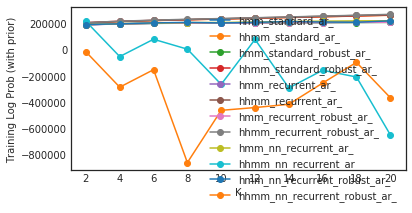

In [16]:
# Plot train and validation likelihoods
plt.figure(figsize=(6, 3))
for transitions in transitionss:
    for observations in observationss:
        hmm_results_prefix = "hmm_{}_{}_".format(transitions, observations)
        hmm_train_lls = [hmm_results[hmm_results_prefix + "K{}".format(K)][1][-1] for K in Ks]
        plt.plot(Ks, hmm_train_lls, '-o', label=hmm_results_prefix)
        
        hhmm_results_prefix = "hhmm_{}_{}_".format(transitions, observations)
        hhmm_train_lls = [hhmm_results[hhmm_results_prefix + "K{}".format(K)][1][-1] for K in Ks]
        plt.plot(Ks, hhmm_train_lls, '-o', label=hhmm_results_prefix)
        
plt.xlabel("K")
plt.xticks(Ks)
plt.ylabel("Training Log Prob (with prior) ")
plt.legend()

/home/scott/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


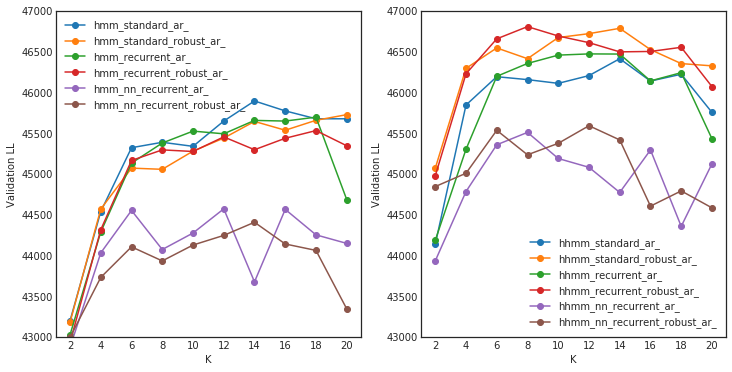

In [17]:
# Plot train and validation likelihoods

# num_bars = len(transitions) * len(observations)

plt.figure(figsize=(12, 6))
for transitions in transitionss:
    for observations in observationss:
        plt.subplot(121)
        hmm_results_prefix = "hmm_{}_{}_".format(transitions, observations)
        hmm_val_lls = [hmm_results[hmm_results_prefix + "K{}".format(K)][2] for K in Ks]
        plt.plot(Ks, hmm_val_lls, '-o', label=hmm_results_prefix)

        plt.subplot(122)
        hhmm_results_prefix = "hhmm_{}_{}_".format(transitions, observations)
        hhmm_val_lls = [hhmm_results[hhmm_results_prefix + "K{}".format(K)][2] for K in Ks]
        plt.plot(Ks, hhmm_val_lls, '-o', label=hhmm_results_prefix)

for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.xlabel("K")
    plt.xticks(Ks)
    plt.ylabel("Validation LL")
    plt.ylim(43000, 47000)
    plt.legend()

# Fit the HHMM to the full train and validation data

In [18]:
def _fit_to_all_data(model):
    lps = model.fit(train_xs + val_xs, tags=train_tags + val_tags, method="em", num_em_iters=100, initialize=False)
    return model, lps

In [19]:
# Fit the HMMs
best_results = {}

for transitions in transitionss:
    for observations in observationss:
        hmm_results_prefix = "hmm_{}_{}".format(transitions, observations)
        hmm_val_lls = [hmm_results[hmm_results_prefix + "_K{}".format(K)][2] for K in Ks]
        best_K = Ks[np.argmax(hmm_val_lls)]
        
        # Fit the best model    
        results_name = "best_" + hmm_results_prefix
        print("Fitting ", results_name, " with K = ", best_K)
        fit = cached(results_dir, results_name)(_fit_to_all_data)
        hmm, _ = fit(hmm_results[hmm_results_prefix + "_K{}".format(best_K)][0])
        
        # Compute the log likelihood of the test data
        test_ll = hmm.log_likelihood(test_xs, tags=test_tags)
        best_results[results_name] = (hmm, test_ll)
        
# Fit the HHMMs
for transitions in transitionss:
    for observations in observationss:
        hhmm_results_prefix = "hhmm_{}_{}".format(transitions, observations)
        hhmm_val_lls = [hhmm_results[hhmm_results_prefix + "_K{}".format(K)][2] for K in Ks]
        best_K = Ks[np.argmax(hhmm_val_lls)]
        
        # Fit the best model    
        results_name = "best_" + hhmm_results_prefix
        print("Fitting ", results_name, " with K = ", best_K)
        fit = cached(results_dir, results_name)(_fit_to_all_data)
        hhmm, _ = fit(hhmm_results[hhmm_results_prefix + "_K{}".format(best_K)][0])
        
        # Compute the log likelihood of the test data
        test_ll = hhmm.log_likelihood(test_xs, tags=test_tags)
        best_results[results_name] = (hhmm, test_ll)
        
with open(os.path.join(results_dir, "best_results.pkl"), "wb") as f:
    pickle.dump(best_results, f)

Fitting  best_hmm_standard_ar  with K =  14
Fitting  best_hmm_standard_robust_ar  with K =  20
Fitting  best_hmm_recurrent_ar  with K =  18
Fitting  best_hmm_recurrent_robust_ar  with K =  18
Fitting  best_hmm_nn_recurrent_ar  with K =  12
Fitting  best_hmm_nn_recurrent_robust_ar  with K =  14
Fitting  best_hhmm_standard_ar  with K =  14
Fitting  best_hhmm_standard_robust_ar  with K =  14
Fitting  best_hhmm_recurrent_ar  with K =  12
Fitting  best_hhmm_recurrent_robust_ar  with K =  8
Fitting  best_hhmm_nn_recurrent_ar  with K =  8
Fitting  best_hhmm_nn_recurrent_robust_ar  with K =  12


/home/scott/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


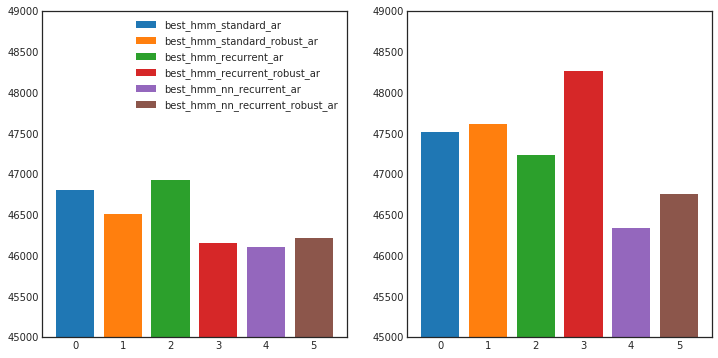

In [20]:
# Plot train and validation likelihoods

plt.figure(figsize=(12, 6))
i = 0
for transitions in transitionss:
    for observations in observationss:
        plt.subplot(121)
        hmm_results_prefix = "best_hmm_{}_{}".format(transitions, observations)
        plt.bar(i, best_results[hmm_results_prefix][1], label=hmm_results_prefix)
        plt.ylim(45000, 49000)
        
        plt.subplot(122)
        hhmm_results_prefix = "best_hhmm_{}_{}".format(transitions, observations)
        plt.bar(i, best_results[hhmm_results_prefix][1], label=hhmm_results_prefix)
        plt.ylim(45000, 49000)
        
        i += 1

plt.subplot(121)
plt.legend()

# Simulate from the model

In [21]:
def simulate_model(name, model, pad=3, N_smpls=20):
    # Get the inferred states
    z_infs = [model.most_likely_states(x, tag=tag) for tag, x in enumerate(xs)]
    model.permute(find_permutation(np.concatenate(z_trues), np.concatenate(z_infs)))
    z_infs = [model.most_likely_states(x, tag=tag) for tag, x in enumerate(xs)]
    
    # Lower the noise
    model_low_noise = copy.deepcopy(model)
    model_low_noise.observations.inv_sigmas -= 4
    
    simulations = []

    for w in range(W):
        # Simulate N_smpls for this worm
        model_simulations_w = []
        for s in range(N_smpls):
            print("Model ", name, " Worm ", w, " sample ", s)
            # Sample data
            Tsmpl = Ts[w]
            zpre, xpre = z_infs[w][-pad:], xs[w][-pad:]
            zsmpl, xsmpl = model_low_noise.sample(Tsmpl, prefix=(zpre, xpre), tag=w, with_noise=True)

            zsmpl = np.concatenate((zpre, zsmpl))
            xsmpl = np.concatenate((xpre, xsmpl))

            # Truncate to stable region
            unstable = np.arange(Tsmpl+pad)[np.any(abs(xsmpl) > 5, axis=1)]
            T_stable = np.min(np.concatenate(([Tsmpl+pad], unstable)))
            zsmpl = zsmpl[:T_stable]
            xsmpl = xsmpl[:T_stable]

            # Project into neural space
            ysmpl = xsmpl.dot(pca.components_) + pca.mean_

            # Append
            model_simulations_w.append((zsmpl, xsmpl, ysmpl))
            
        # Append this worm
        simulations.append(model_simulations_w)
        
    return simulations

In [25]:
simulations = {}
for name, (model, _) in best_results.items(): 
    print("Simulating ", name)
    _sim = cached(results_dir, name + "_sim")(simulate_model)
    simulations[name] = _sim(name, model)

Simulating  best_hmm_standard_ar
Simulating  best_hmm_standard_robust_ar
Simulating  best_hmm_recurrent_ar
Simulating  best_hmm_recurrent_robust_ar
Simulating  best_hmm_nn_recurrent_ar
Simulating  best_hmm_nn_recurrent_robust_ar
Simulating  best_hhmm_standard_ar
Simulating  best_hhmm_standard_robust_ar
Simulating  best_hhmm_recurrent_ar
Model  best_hhmm_recurrent_ar  Worm  0  sample  0
Model  best_hhmm_recurrent_ar  Worm  0  sample  1
Model  best_hhmm_recurrent_ar  Worm  0  sample  2
Model  best_hhmm_recurrent_ar  Worm  0  sample  3
Model  best_hhmm_recurrent_ar  Worm  0  sample  4
Model  best_hhmm_recurrent_ar  Worm  0  sample  5
Model  best_hhmm_recurrent_ar  Worm  0  sample  6
Model  best_hhmm_recurrent_ar  Worm  0  sample  7
Model  best_hhmm_recurrent_ar  Worm  0  sample  8
Model  best_hhmm_recurrent_ar  Worm  0  sample  9
Model  best_hhmm_recurrent_ar  Worm  0  sample  10
Model  best_hhmm_recurrent_ar  Worm  0  sample  11
Model  best_hhmm_recurrent_ar  Worm  0  sample  12
Model  b

Model  best_hhmm_recurrent_robust_ar  Worm  2  sample  9
Model  best_hhmm_recurrent_robust_ar  Worm  2  sample  10
Model  best_hhmm_recurrent_robust_ar  Worm  2  sample  11
Model  best_hhmm_recurrent_robust_ar  Worm  2  sample  12
Model  best_hhmm_recurrent_robust_ar  Worm  2  sample  13
Model  best_hhmm_recurrent_robust_ar  Worm  2  sample  14
Model  best_hhmm_recurrent_robust_ar  Worm  2  sample  15
Model  best_hhmm_recurrent_robust_ar  Worm  2  sample  16
Model  best_hhmm_recurrent_robust_ar  Worm  2  sample  17
Model  best_hhmm_recurrent_robust_ar  Worm  2  sample  18
Model  best_hhmm_recurrent_robust_ar  Worm  2  sample  19
Model  best_hhmm_recurrent_robust_ar  Worm  3  sample  0
Model  best_hhmm_recurrent_robust_ar  Worm  3  sample  1
Model  best_hhmm_recurrent_robust_ar  Worm  3  sample  2
Model  best_hhmm_recurrent_robust_ar  Worm  3  sample  3
Model  best_hhmm_recurrent_robust_ar  Worm  3  sample  4
Model  best_hhmm_recurrent_robust_ar  Worm  3  sample  5
Model  best_hhmm_recu

Model  best_hhmm_nn_recurrent_ar  Worm  4  sample  18
Model  best_hhmm_nn_recurrent_ar  Worm  4  sample  19
Simulating  best_hhmm_nn_recurrent_robust_ar
Model  best_hhmm_nn_recurrent_robust_ar  Worm  0  sample  0
Model  best_hhmm_nn_recurrent_robust_ar  Worm  0  sample  1
Model  best_hhmm_nn_recurrent_robust_ar  Worm  0  sample  2
Model  best_hhmm_nn_recurrent_robust_ar  Worm  0  sample  3
Model  best_hhmm_nn_recurrent_robust_ar  Worm  0  sample  4
Model  best_hhmm_nn_recurrent_robust_ar  Worm  0  sample  5
Model  best_hhmm_nn_recurrent_robust_ar  Worm  0  sample  6
Model  best_hhmm_nn_recurrent_robust_ar  Worm  0  sample  7
Model  best_hhmm_nn_recurrent_robust_ar  Worm  0  sample  8
Model  best_hhmm_nn_recurrent_robust_ar  Worm  0  sample  9
Model  best_hhmm_nn_recurrent_robust_ar  Worm  0  sample  10
Model  best_hhmm_nn_recurrent_robust_ar  Worm  0  sample  11
Model  best_hhmm_nn_recurrent_robust_ar  Worm  0  sample  12
Model  best_hhmm_nn_recurrent_robust_ar  Worm  0  sample  13
Mod